In [1]:
from numpy import array
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# split a univariate sequence into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# fixem random seed
np.random.seed(7)

dadesSau = read_csv('dadesSau.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]

n_steps_in = 17
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

In [2]:
from scipy.stats import uniform
from scipy.stats import randint
c=[]
epsilon=[]
gamma=[]

for i in range(500):
    c.append((randint.rvs(5, 125)))
    epsilon.append(round(uniform.rvs(0.0001, 0.1),4))
    gamma.append(round(uniform.rvs(0.01, 0.9),4))

In [4]:
#Simulació RandomizedSearchCV per SVM
resultat=[]

for c_v, eps, gam in zip(c, epsilon, gamma):
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=c_v, gamma=gam, epsilon=eps))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(c_v, gam, eps, RMSE_TOT)
    resultat.append((c_v, gam, eps, RMSE_days,RMSE_TOT))


52 0.2971 0.0228 5.710920039078279
88 0.8902 0.0724 7.553980913921119
19 0.0881 0.0265 5.782480696293628
47 0.4599 0.0269 5.784559140907355
73 0.3078 0.087 6.962181917435358
5 0.2693 0.0067 5.726641982881256
24 0.3214 0.0695 6.374915771450283
61 0.0324 0.0932 7.0721235598529235
66 0.2173 0.0951 7.3229341451196746
83 0.8539 0.0792 7.588746086636945
92 0.6854 0.0524 6.510415902135067
53 0.1004 0.0194 5.73687642786017
36 0.3451 0.0492 6.008537374000259
76 0.2589 0.035 5.809476057590306
69 0.2926 0.077 6.564889894748536
124 0.0852 0.0144 5.723566423519876
102 0.6017 0.0354 6.083920884506989
24 0.4 0.0922 7.2024779986948415
35 0.7242 0.0987 7.586883339236702
86 0.3901 0.0742 6.6284717978672
55 0.6013 0.0624 6.4797563339497435
80 0.0113 0.0416 5.890248520562528
98 0.7136 0.0441 6.4160770947977
72 0.8699 0.0697 7.287484675619512
58 0.1484 0.0955 7.29496215305459
53 0.2216 0.0594 6.166591478243592
59 0.7736 0.0946 7.723670893492043
55 0.7647 0.0663 6.803662153626794
81 0.4267 0.031 5.837427825

54 0.2172 0.0423 5.889079581564521
9 0.7234 0.0436 5.988597509586506
22 0.5307 0.0265 5.771848467831668
92 0.1576 0.0839 6.8297523240853435
66 0.2967 0.0868 6.944846307964921
69 0.705 0.0293 6.031234750513977
62 0.2408 0.0485 5.976563278568896
6 0.8287 0.0799 6.857067364320966
111 0.4526 0.0413 6.006617846098665
24 0.5482 0.0683 6.449070058937293
109 0.1281 0.0764 6.5395850380697595
68 0.2394 0.0671 6.303861723908235
6 0.2133 0.0636 6.320352055109649
15 0.1501 0.0677 6.347236442932611
15 0.2527 0.0753 6.5397180487164475
115 0.3818 0.0876 7.057863005590476
35 0.5956 0.0982 7.466007781597046
77 0.6477 0.0056 5.8781503953352
46 0.2628 0.0985 7.485696963578524
104 0.2383 0.0807 6.672964154619897
111 0.5673 0.0827 7.177683903866214
34 0.2867 0.0556 6.094914561933139
117 0.9032 0.0002 6.4998500742767895
41 0.1515 0.0132 5.697338410989504
100 0.379 0.0077 5.750012752907821
72 0.7308 0.022 6.012286862004428
118 0.1556 0.0698 6.380978054604056
74 0.0622 0.0417 5.901879623853924
50 0.4987 0.0188

5 0.2701 0.0903 7.118677110335346
95 0.1966 0.0377 5.824938615924861
106 0.0478 0.0527 6.042413622701478
41 0.0119 0.0295 5.798035012741774
106 0.6203 0.0697 6.855931953041532
45 0.7695 0.0296 6.026153335518435
98 0.251 0.0484 5.985328854664615
79 0.1508 0.0396 5.873148322704783
31 0.7283 0.0699 6.719738909903412
112 0.4475 0.0894 7.175609998693705
5 0.6666 0.0593 6.222438319614015
86 0.1891 0.04 5.861965895965276
120 0.6904 0.0863 7.5607968081373365
104 0.3233 0.0872 6.98769351056271
112 0.6085 0.0227 5.93437374614995
11 0.0752 0.0792 6.621729568750713
69 0.8495 0.0315 6.254214346169646
80 0.7123 0.0709 6.965508209734044
52 0.7836 0.0812 7.266092984453616
40 0.2353 0.0893 7.077723613952343
6 0.1592 0.0025 5.768920562159848
99 0.558 0.0354 6.0133795066104945
78 0.8029 0.0444 6.508811886140083
43 0.4136 0.0023 5.731491310289724
56 0.12 0.0529 6.08311020370331
99 0.3003 0.0065 5.715586907425086
97 0.5556 0.0374 6.0429574626256475
34 0.1931 0.0147 5.674091851370874
46 0.4834 0.06 6.269038

In [11]:
varlist = []
for i in range(len(c)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['C','gamma',  'epsilon','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]


,C,gamma,epsilon,RMSE_dies,RMSE_total
0,24,0.2788,0.0127,"[1.0061150722210668, 1.8647285931381905, 2.606...",5.662740
1,53,0.2493,0.0110,"[0.9647005770535061, 1.8504017718591794, 2.575...",5.662919
2,91,0.2017,0.0065,"[0.899492038202247, 1.7968617892892333, 2.5535...",5.664604
3,44,0.1969,0.0149,"[1.036489450738026, 1.8732104477309337, 2.6229...",5.665068
4,81,0.2240,0.0161,"[1.0671139023075022, 1.8796593472645096, 2.618...",5.665332
5,18,0.2998,0.0138,"[1.033999633445497, 1.8766682831307588, 2.6260...",5.668457
6,90,0.1619,0.0068,"[0.9012734555179474, 1.7970315278934037, 2.552...",5.669510
7,34,0.1931,0.0147,"[1.0421560010330235, 1.8801715473031266, 2.632...",5.674092
8,19,0.2954,0.0040,"[0.8879900526721983, 1.792853805419745, 2.5557...",5.681359
9,44,0.1709,0.0075,"[0.9124111143800062, 1.8075337497126924, 2.566...",5.682910


In [15]:
# Simulació GridSearchCV random forest
import numpy as np
resultatsf = []
gamma = np.arange(0.2650,0.2851,0.0020)
c = np.arange(18,31,1)
epsilon = np.arange(0.010,0.020,0.001)

for c_v in c:
    for eps in epsilon:
        resultat = []
        for gam in gamma:
            regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=c_v, gamma=gam, epsilon=eps))
            regr_multisvr.fit(train_X, train_Y)
            # Predict on new data
            testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
            testPredict = scaler.inverse_transform(testPredict)
            test_YR = scaler.inverse_transform(test_Y)

            RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
            print(c_v, gam, eps, RMSE_TOT)
            resultat.append((c_v, gam, eps, RMSE_days,RMSE_TOT))
        
        resultatsf.append(resultat)


18 0.265 0.01 5.668428979498803
18 0.267 0.01 5.668292471962507
18 0.269 0.01 5.66821836622677
18 0.271 0.01 5.668252769799949
18 0.273 0.01 5.668363216714416
18 0.275 0.01 5.668308851059413
18 0.277 0.01 5.6678453364079235
18 0.279 0.01 5.6679124859426295
18 0.281 0.01 5.667865080664157
18 0.28300000000000003 0.01 5.667907151254142
18 0.28500000000000003 0.01 5.667897339176148
18 0.265 0.011 5.667456004819944
18 0.267 0.011 5.666675643956215
18 0.269 0.011 5.666355230929461
18 0.271 0.011 5.666504213494403
18 0.273 0.011 5.665745691006291
18 0.275 0.011 5.665800900057592
18 0.277 0.011 5.665911860214342
18 0.279 0.011 5.665893805478185
18 0.281 0.011 5.6655929444685045
18 0.28300000000000003 0.011 5.665896779602242
18 0.28500000000000003 0.011 5.666079603524938
18 0.265 0.011999999999999999 5.6680018822022955
18 0.267 0.011999999999999999 5.667916775798708
18 0.269 0.011999999999999999 5.667483809562682
18 0.271 0.011999999999999999 5.667674732512962
18 0.273 0.011999999999999999 5.66

19 0.265 0.015999999999999993 5.676816160437792
19 0.267 0.015999999999999993 5.676780697887699
19 0.269 0.015999999999999993 5.675908267744047
19 0.271 0.015999999999999993 5.675821847813404
19 0.273 0.015999999999999993 5.675349600136837
19 0.275 0.015999999999999993 5.6753697086228465
19 0.277 0.015999999999999993 5.675033715658374
19 0.279 0.015999999999999993 5.674961197285588
19 0.281 0.015999999999999993 5.674867278951709
19 0.28300000000000003 0.015999999999999993 5.674930780886475
19 0.28500000000000003 0.015999999999999993 5.674572522468787
19 0.265 0.016999999999999994 5.677430650179773
19 0.267 0.016999999999999994 5.677549463937944
19 0.269 0.016999999999999994 5.677361221504577
19 0.271 0.016999999999999994 5.677930727692374
19 0.273 0.016999999999999994 5.677609506875949
19 0.275 0.016999999999999994 5.677721143224525
19 0.277 0.016999999999999994 5.678276288011595
19 0.279 0.016999999999999994 5.678590926579912
19 0.281 0.016999999999999994 5.679034166929242
19 0.283000

21 0.265 0.011999999999999999 5.6649658278188735
21 0.267 0.011999999999999999 5.6652830133731324
21 0.269 0.011999999999999999 5.665366099060887
21 0.271 0.011999999999999999 5.665206402219656
21 0.273 0.011999999999999999 5.665347323338171
21 0.275 0.011999999999999999 5.664122746434294
21 0.277 0.011999999999999999 5.664449138692613
21 0.279 0.011999999999999999 5.664347809198355
21 0.281 0.011999999999999999 5.665102478166342
21 0.28300000000000003 0.011999999999999999 5.664627454012117
21 0.28500000000000003 0.011999999999999999 5.664750587897536
21 0.265 0.012999999999999998 5.663222415745508
21 0.267 0.012999999999999998 5.663470281199714
21 0.269 0.012999999999999998 5.663163502996437
21 0.271 0.012999999999999998 5.663082929828403
21 0.273 0.012999999999999998 5.662673489551994
21 0.275 0.012999999999999998 5.66253287637254
21 0.277 0.012999999999999998 5.6631962684532455
21 0.279 0.012999999999999998 5.663175277808513
21 0.281 0.012999999999999998 5.663536052568054
21 0.28300

22 0.273 0.016999999999999994 5.67649341488951
22 0.275 0.016999999999999994 5.676901778266311
22 0.277 0.016999999999999994 5.6774221069473425
22 0.279 0.016999999999999994 5.678620153101667
22 0.281 0.016999999999999994 5.67887319187429
22 0.28300000000000003 0.016999999999999994 5.679844435228443
22 0.28500000000000003 0.016999999999999994 5.680611187094504
22 0.265 0.017999999999999995 5.6781311147744775
22 0.267 0.017999999999999995 5.678237868346303
22 0.269 0.017999999999999995 5.678831344460052
22 0.271 0.017999999999999995 5.678917252071298
22 0.273 0.017999999999999995 5.679721451773293
22 0.275 0.017999999999999995 5.68027622627415
22 0.277 0.017999999999999995 5.6803504923369506
22 0.279 0.017999999999999995 5.681125140042734
22 0.281 0.017999999999999995 5.6813330528284895
22 0.28300000000000003 0.017999999999999995 5.681070941382341
22 0.28500000000000003 0.017999999999999995 5.6819704250643195
22 0.265 0.018999999999999993 5.682534999736152
22 0.267 0.018999999999999993 

24 0.273 0.012999999999999998 5.661938202306383
24 0.275 0.012999999999999998 5.662261522356719
24 0.277 0.012999999999999998 5.662782081913427
24 0.279 0.012999999999999998 5.66280419096546
24 0.281 0.012999999999999998 5.662951888379539
24 0.28300000000000003 0.012999999999999998 5.663210215501837
24 0.28500000000000003 0.012999999999999998 5.663571140344638
24 0.265 0.013999999999999997 5.66359324671123
24 0.267 0.013999999999999997 5.6632980511409015
24 0.269 0.013999999999999997 5.663285005567225
24 0.271 0.013999999999999997 5.663467536524909
24 0.273 0.013999999999999997 5.663542952241467
24 0.275 0.013999999999999997 5.662591511005296
24 0.277 0.013999999999999997 5.663635486108044
24 0.279 0.013999999999999997 5.663891116863848
24 0.281 0.013999999999999997 5.66459850638543
24 0.28300000000000003 0.013999999999999997 5.664890636302738
24 0.28500000000000003 0.013999999999999997 5.665519766312474
24 0.265 0.014999999999999996 5.666970669869047
24 0.267 0.014999999999999996 5.66

25 0.28300000000000003 0.017999999999999995 5.680808336456508
25 0.28500000000000003 0.017999999999999995 5.6811564502591185
25 0.265 0.018999999999999993 5.6812262626783925
25 0.267 0.018999999999999993 5.681196372866783
25 0.269 0.018999999999999993 5.681064692732006
25 0.271 0.018999999999999993 5.681442230069505
25 0.273 0.018999999999999993 5.681731469758348
25 0.275 0.018999999999999993 5.681794287655898
25 0.277 0.018999999999999993 5.682605530984545
25 0.279 0.018999999999999993 5.682421646251747
25 0.281 0.018999999999999993 5.682346122682799
25 0.28300000000000003 0.018999999999999993 5.682774910833112
25 0.28500000000000003 0.018999999999999993 5.683115453260361
26 0.265 0.01 5.6632357140831715
26 0.267 0.01 5.662851910532303
26 0.269 0.01 5.662582154318545
26 0.271 0.01 5.662255546156128
26 0.273 0.01 5.662616588717598
26 0.275 0.01 5.662518544869674
26 0.277 0.01 5.662746087647107
26 0.279 0.01 5.663150778754486
26 0.281 0.01 5.664082691995323
26 0.28300000000000003 0.01 5

27 0.28300000000000003 0.013999999999999997 5.6662114758585975
27 0.28500000000000003 0.013999999999999997 5.667029841252552
27 0.265 0.014999999999999996 5.66501839930857
27 0.267 0.014999999999999996 5.6653878293375115
27 0.269 0.014999999999999996 5.665236586080924
27 0.271 0.014999999999999996 5.666356925139428
27 0.273 0.014999999999999996 5.666527227457444
27 0.275 0.014999999999999996 5.667384157221752
27 0.277 0.014999999999999996 5.668409630818064
27 0.279 0.014999999999999996 5.66983740029427
27 0.281 0.014999999999999996 5.670330522075943
27 0.28300000000000003 0.014999999999999996 5.670630323821074
27 0.28500000000000003 0.014999999999999996 5.670906901460659
27 0.265 0.015999999999999993 5.670607931921247
27 0.267 0.015999999999999993 5.671157405200647
27 0.269 0.015999999999999993 5.671824175768895
27 0.271 0.015999999999999993 5.672084626418394
27 0.273 0.015999999999999993 5.672626147838254
27 0.275 0.015999999999999993 5.67384244975227
27 0.277 0.015999999999999993 5.6

29 0.271 0.01 5.661883667294113
29 0.273 0.01 5.662607176645216
29 0.275 0.01 5.6634411416919175
29 0.277 0.01 5.664183595940008
29 0.279 0.01 5.664107709718395
29 0.281 0.01 5.665543530745163
29 0.28300000000000003 0.01 5.665501245910847
29 0.28500000000000003 0.01 5.666082823742707
29 0.265 0.011 5.660157002344415
29 0.267 0.011 5.659739235954238
29 0.269 0.011 5.6602334816840845
29 0.271 0.011 5.66064323910373
29 0.273 0.011 5.660389872509626
29 0.275 0.011 5.661172472731817
29 0.277 0.011 5.6621501041407525
29 0.279 0.011 5.662275695808435
29 0.281 0.011 5.66387552269388
29 0.28300000000000003 0.011 5.664268845616631
29 0.28500000000000003 0.011 5.664964145292
29 0.265 0.011999999999999999 5.6603950291980425
29 0.267 0.011999999999999999 5.660912525779221
29 0.269 0.011999999999999999 5.660594228779877
29 0.271 0.011999999999999999 5.660674458501079
29 0.273 0.011999999999999999 5.661779804038411
29 0.275 0.011999999999999999 5.662171049194206
29 0.277 0.011999999999999999 5.662767

30 0.269 0.015999999999999993 5.672824632863541
30 0.271 0.015999999999999993 5.6729463129904705
30 0.273 0.015999999999999993 5.673132472239627
30 0.275 0.015999999999999993 5.672655882608075
30 0.277 0.015999999999999993 5.672471043199961
30 0.279 0.015999999999999993 5.672420889966666
30 0.281 0.015999999999999993 5.672884959978898
30 0.28300000000000003 0.015999999999999993 5.672930497341837
30 0.28500000000000003 0.015999999999999993 5.673136544253597
30 0.265 0.016999999999999994 5.676208916194714
30 0.267 0.016999999999999994 5.675433833274688
30 0.269 0.016999999999999994 5.676160332228494
30 0.271 0.016999999999999994 5.676526832731198
30 0.273 0.016999999999999994 5.675936302935432
30 0.275 0.016999999999999994 5.67616638761216
30 0.277 0.016999999999999994 5.675919539512914
30 0.279 0.016999999999999994 5.675536169409667
30 0.281 0.016999999999999994 5.676061255214814
30 0.28300000000000003 0.016999999999999994 5.676103654089774
30 0.28500000000000003 0.016999999999999994 5.

In [16]:
resultatsEpDe = pd.DataFrame(resultatsf)
varlist = []
for i in range(len(c)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['C', 'gamma', 'epsilon', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,C,gamma,epsilon,RMSE_dies,RMSE_total
0,19,0.281,0.011,"[0.9780688723252757, 1.8596418795782765, 2.592...",5.664415
1,19,0.275,0.011,"[0.9721777292970063, 1.8581179973190975, 2.591...",5.664430
2,19,0.279,0.011,"[0.9738118985324238, 1.859196245118679, 2.5936...",5.664784
3,19,0.277,0.011,"[0.9749581697594049, 1.8594207249623294, 2.593...",5.664802
4,19,0.273,0.011,"[0.9773409819319873, 1.858533599257646, 2.5918...",5.664999
5,19,0.267,0.011,"[0.9699581937107837, 1.8570001225039672, 2.592...",5.665157
6,19,0.265,0.011,"[0.9745206956523381, 1.8561914393025232, 2.594...",5.665240
7,19,0.285,0.011,"[0.973403608264873, 1.8589607070056242, 2.5930...",5.665391
8,19,0.283,0.011,"[0.9738775787439077, 1.8608350568621916, 2.593...",5.665453
9,19,0.285,0.012,"[0.9981200453853607, 1.8651207437897293, 2.603...",5.665474


In [18]:
import numpy as np
n_steps_in = np.arange(5,101,2)
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, dataset)
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=24, gamma=0.2788, epsilon=0.0127))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

5.853326099448308 5
5.845614172517468 7
5.821062812777134 9
5.761789536668687 11
5.700731607272981 13
5.680252887298319 15
5.662740054016557 17
5.681626183877599 19
5.728572440163969 21
5.831329551291723 23
6.06694031069884 25
6.434316332321871 27
6.848422252171525 29
7.30358174049406 31
7.724728789151746 33
8.05491202441594 35
8.374000669777859 37
8.716761285112872 39
9.000374433924112 41
9.330974604895825 43
9.691822611956088 45
9.979442666518004 47
10.204100334896928 49
10.499082059211887 51
10.788355347818996 53
11.147776820790222 55
11.554165707753373 57
11.977026409380493 59
12.600318302225281 61
13.036844471337732 63
13.48516631881607 65
14.125404826055272 67
14.671019478587466 69
15.099379982053529 71
15.182174472043744 73
15.278754628633461 75
15.914715828145416 77
16.716884784245465 79
17.433376633433404 81
18.15153089147435 83
18.820206978250486 85
19.174811726892926 87
19.478931213784907 89
19.69512107122433 91
19.872434799641574 93
20.027270933828714 95
20.324799813087242 

In [19]:
import numpy as np
n_steps_in = [16,17,18]
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, dataset)
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=24, gamma=0.2788, epsilon=0.0127))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    testPredict = scaler.inverse_transform(testPredict)
    test_YR = scaler.inverse_transform(test_Y)

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

5.669926158076553 16
5.662740054016557 17
5.6683573768953766 18


In [4]:
import numpy as np
n_steps_in =17
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)
regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=24, gamma=0.2788, epsilon=0.0127))
regr_multisvr.fit(train_X, train_Y)
# Predict on new data
testPredict = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(test_Y)

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.662740054016557


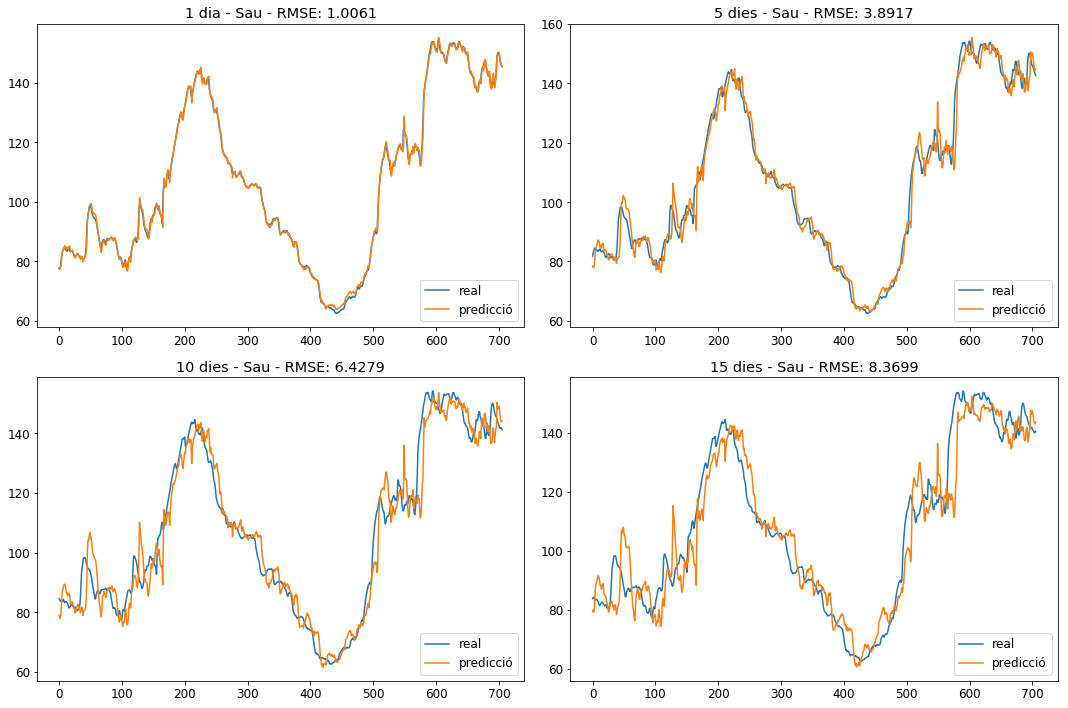

In [5]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],4))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],4))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],4))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],4))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [6]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[1.0061150722210668, 1.8647285931381905, 2.606391483047672, 3.2766202020293806, 3.8916853747603293, 4.446907160857386, 4.991453908530747, 5.504054050807001, 5.978675404918064, 6.427914061379497, 6.863521552290384, 7.264679142403786, 7.630871821686109, 7.976182219557462, 8.369894746572957]
╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1.00612 │ 1.86473 │ 2.60639 │ 3.27662 │ 3.89169 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.44691 │ 4.99145 │ 5.50405 │ 5.97868 │  6.42791 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [8]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.0061,1.8647,2.6064,3.2766,3.8917,4.4469,4.9915,5.5041,5.9787,6.4279,6.8635,7.2647,7.6309,7.9762,8.3699,5.6627
R2,0.9986,0.9953,0.9908,0.9855,0.9795,0.9733,0.9664,0.9592,0.9519,0.9445,0.9368,0.9293,0.9221,0.9150,0.9065,0.9568
MAE,0.7099,1.2746,1.8070,2.2898,2.6945,3.0478,3.4554,3.8694,4.2700,4.6582,5.0181,5.3547,5.6737,5.9978,6.3386,3.7640
MSE,1.0123,3.4772,6.7933,10.7362,15.1452,19.7750,24.9146,30.2946,35.7446,41.3181,47.1079,52.7756,58.2302,63.6195,70.0551,32.0666


In [9]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.006,1.865,2.606,3.277,3.892,4.447,4.991,5.504,5.979,6.428,6.864,7.265,7.631,7.976,8.37,5.663


In [10]:
resultsDF.to_csv('svm-uni-sau.csv', sep=',', encoding='utf-8')